# Feature Engineering for Trading

This notebook demonstrates the feature engineering process for our trading model, including:
- Adding technical indicators
- Creating price and volume features
- Generating target variables
- Analyzing feature correlations

In [15]:
# Add parent directory to path to import from src
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from src modules
from src.data.loader import load_data, preprocess_data
from src.data.features import (add_technical_indicators, add_price_features, 
                              add_volume_features, generate_target,
                              prepare_features)
from src.utils.helpers import set_pandas_display_options

# Set display options
set_pandas_display_options()

# Matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

## 1. Load and Preprocess Data

In [16]:
# Load 15-minute data
file_path = '../USATECH.IDXUSD_Candlestick_15_M_BID_01.01.2023-18.01.2025.csv'
df_raw = load_data(file_path)
df = preprocess_data(df_raw)

print(f"Loaded {len(df)} rows from {df.index.min()} to {df.index.max()}")
df.head()

Loaded 50557 rows from 2023-01-02 06:00:00+07:00 to 2025-01-18 04:00:00+07:00


,Open,High,Low,Close,Volume
timestamp,,,,,
2023-01-02 06:00:00+07:00,10958.4390,10958.4390,10958.4390,10958.4390,0.0000
2023-01-02 06:15:00+07:00,10958.4390,10958.4390,10958.4390,10958.4390,0.0000
2023-01-02 06:30:00+07:00,10958.4390,10958.4390,10958.4390,10958.4390,0.0000
2023-01-02 06:45:00+07:00,10958.4390,10958.4390,10958.4390,10958.4390,0.0000
2023-01-02 07:00:00+07:00,10958.4390,10958.4390,10958.4390,10958.4390,0.0000


## 2. Add Technical Indicators

Let's add common technical indicators to our data.

In [17]:
# Add technical indicators
df_indicators = add_technical_indicators(df)

# Display the new columns
new_columns = [col for col in df_indicators.columns if col not in df.columns]
print(f"Added {len(new_columns)} new technical indicators:")
print(new_columns)

# Show first few rows with indicators
df_indicators[new_columns].head()

Added 14 new technical indicators:
['SMA20', 'SMA50', 'SMA200', 'EMA12', 'EMA26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ATR', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'ADX']


,SMA20,SMA50,SMA200,EMA12,EMA26,RSI,MACD,MACD_Signal,MACD_Hist,ATR,BB_Upper,BB_Middle,BB_Lower,ADX
timestamp,,,,,,,,,,,,,,
2023-01-02 06:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 06:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 06:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 06:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 07:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualize Technical Indicators

Let's visualize some of the technical indicators to understand their behavior.

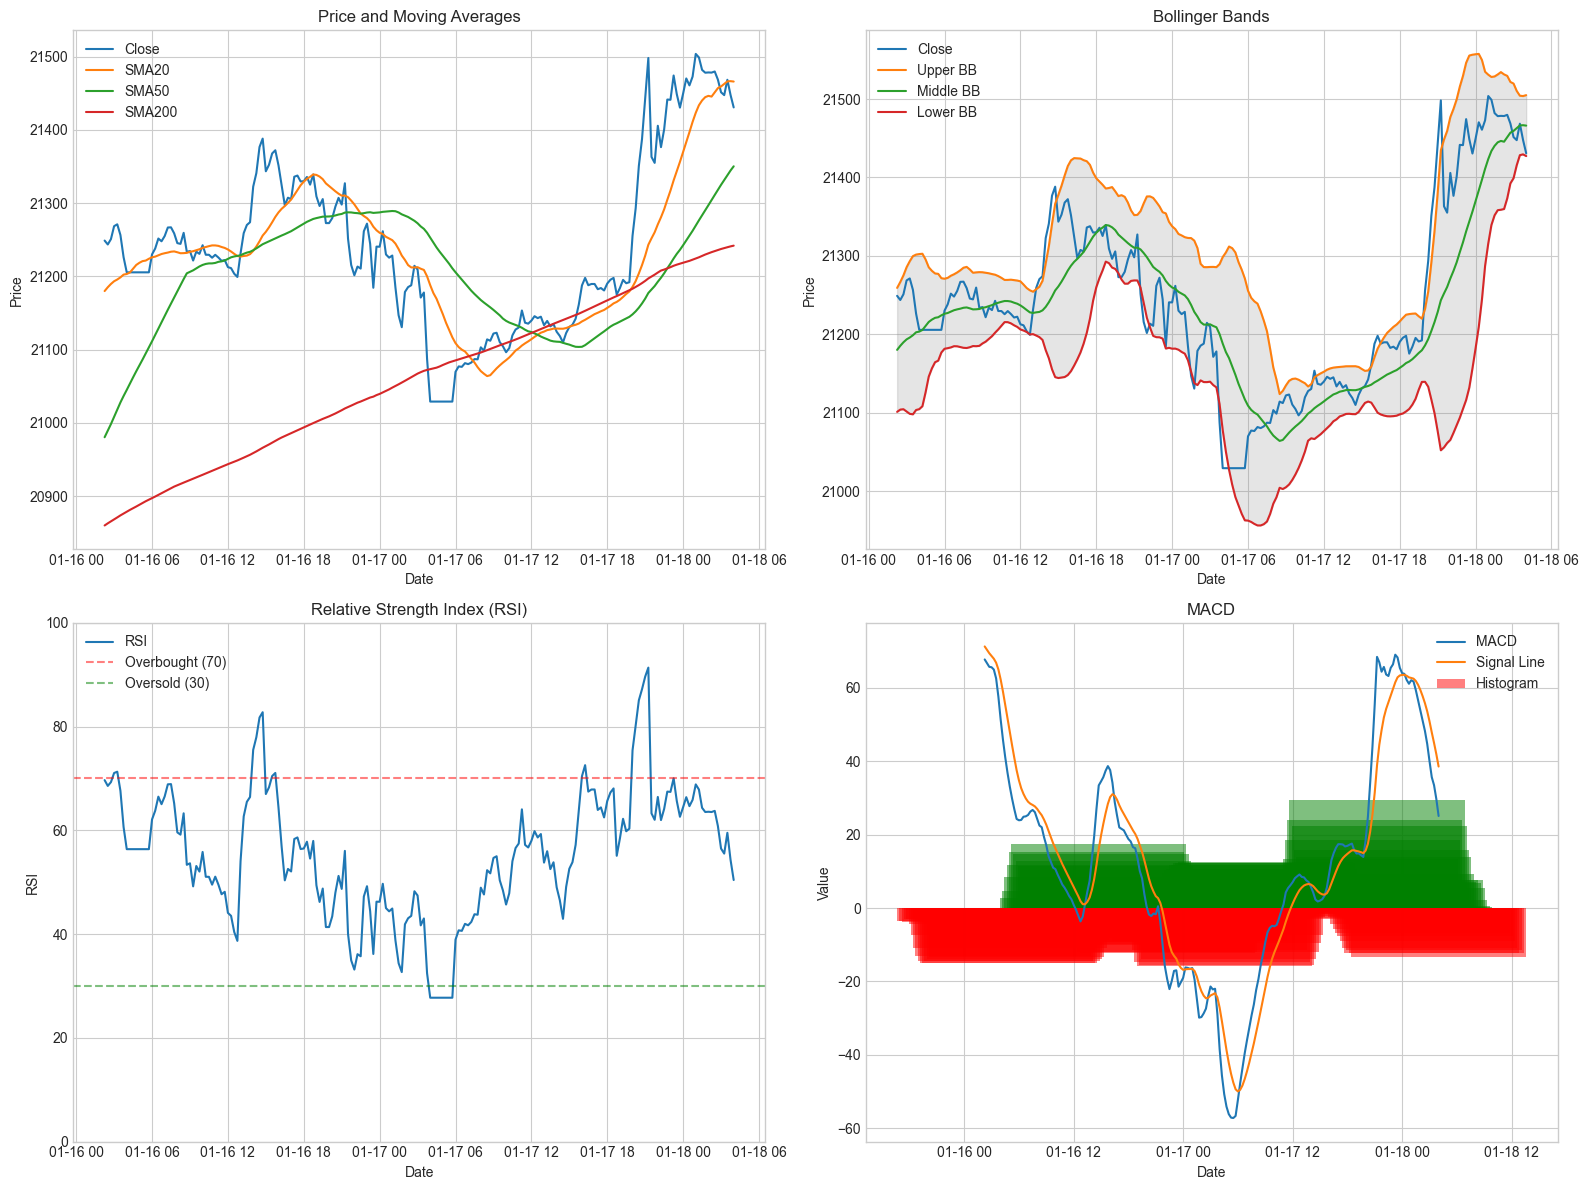

In [18]:
# Select a recent time period for visualization
recent_data = df_indicators.iloc[-200:]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Price and Moving Averages
axes[0, 0].plot(recent_data.index, recent_data['Close'], label='Close')
axes[0, 0].plot(recent_data.index, recent_data['SMA20'], label='SMA20')
axes[0, 0].plot(recent_data.index, recent_data['SMA50'], label='SMA50')
axes[0, 0].plot(recent_data.index, recent_data['SMA200'], label='SMA200')
axes[0, 0].set_title('Price and Moving Averages')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Bollinger Bands
axes[0, 1].plot(recent_data.index, recent_data['Close'], label='Close')
axes[0, 1].plot(recent_data.index, recent_data['BB_Upper'], label='Upper BB')
axes[0, 1].plot(recent_data.index, recent_data['BB_Middle'], label='Middle BB')
axes[0, 1].plot(recent_data.index, recent_data['BB_Lower'], label='Lower BB')
axes[0, 1].fill_between(recent_data.index, 
                       recent_data['BB_Upper'], 
                       recent_data['BB_Lower'], 
                       alpha=0.2, color='gray')
axes[0, 1].set_title('Bollinger Bands')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: RSI
axes[1, 0].plot(recent_data.index, recent_data['RSI'], label='RSI')
axes[1, 0].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
axes[1, 0].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
axes[1, 0].set_title('Relative Strength Index (RSI)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: MACD
axes[1, 1].plot(recent_data.index, recent_data['MACD'], label='MACD')
axes[1, 1].plot(recent_data.index, recent_data['MACD_Signal'], label='Signal Line')
axes[1, 1].bar(recent_data.index, recent_data['MACD_Hist'], 
              color=['green' if x > 0 else 'red' for x in recent_data['MACD_Hist']], 
              alpha=0.5, label='Histogram')
axes[1, 1].set_title('MACD')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 3. Add Price and Volume Features

Now let's add additional price-based and volume-based features.

In [19]:
# Add price features
df_price = add_price_features(df_indicators)

# Display the new columns
new_price_columns = [col for col in df_price.columns if col not in df_indicators.columns]
print(f"Added {len(new_price_columns)} new price features:")
print(new_price_columns)

# Show first few rows with price features
df_price[new_price_columns].head()

Added 13 new price features:
['Close_SMA20_Ratio', 'Close_SMA50_Ratio', 'Close_SMA200_Ratio', 'BB_Position', 'Golden_Cross', 'Death_Cross', 'MACD_Cross_Above', 'MACD_Cross_Below', 'Daily_Return', 'Weekly_Return', 'Monthly_Return', 'DayOfWeek', 'HourOfDay']


,Close_SMA20_Ratio,Close_SMA50_Ratio,Close_SMA200_Ratio,BB_Position,Golden_Cross,Death_Cross,MACD_Cross_Above,MACD_Cross_Below,Daily_Return,Weekly_Return,Monthly_Return,DayOfWeek,HourOfDay
timestamp,,,,,,,,,,,,,
2023-01-02 06:00:00+07:00,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,NaN,0,6
2023-01-02 06:15:00+07:00,NaN,NaN,NaN,NaN,0,0,0,0,0.0000,NaN,NaN,0,6
2023-01-02 06:30:00+07:00,NaN,NaN,NaN,NaN,0,0,0,0,0.0000,NaN,NaN,0,6
2023-01-02 06:45:00+07:00,NaN,NaN,NaN,NaN,0,0,0,0,0.0000,NaN,NaN,0,6
2023-01-02 07:00:00+07:00,NaN,NaN,NaN,NaN,0,0,0,0,0.0000,NaN,NaN,0,7


In [20]:
# Add volume features
df_volume = add_volume_features(df_price)

# Display the new columns
new_volume_columns = [col for col in df_volume.columns if col not in df_price.columns]
print(f"Added {len(new_volume_columns)} new volume features:")
print(new_volume_columns)

# Show first few rows with volume features
df_volume[new_volume_columns].head()

Added 4 new volume features:
['Volume_SMA20', 'Volume_Ratio', 'High_Volume', 'Volume_Trend']


,Volume_SMA20,Volume_Ratio,High_Volume,Volume_Trend
timestamp,,,,
2023-01-02 06:00:00+07:00,NaN,NaN,0,NaN
2023-01-02 06:15:00+07:00,NaN,NaN,0,NaN
2023-01-02 06:30:00+07:00,NaN,NaN,0,NaN
2023-01-02 06:45:00+07:00,NaN,NaN,0,NaN
2023-01-02 07:00:00+07:00,NaN,NaN,0,NaN


## 4. Generate Target Variable

Now let's create a target variable based on future price movements.

In [27]:
# Generate target variable
future_periods = 48  # Look ahead 48 periods
profit_target = 0.02  # 2% profit target
stop_loss = 0.005  # 0.5% stop loss

df_target = generate_target(df_volume, future_periods, profit_target, stop_loss)

# Check target distribution
target_counts = df_target['Target'].value_counts()
print("Target Distribution:")
print(target_counts)
print(f"Percentage of long signals: {target_counts[1] / len(df_target) * 100:.2f}%")
print(f"Percentage of short signals: {target_counts[-1] / len(df_target) * 100:.2f}%")
print(f"Percentage of neutral: {target_counts[0] / len(df_target) * 100:.2f}%")

Target Distribution:
Target
 0    48546
-1     1061
 1      950
Name: count, dtype: int64
Percentage of long signals: 1.88%
Percentage of short signals: 2.10%
Percentage of neutral: 96.02%


### Visualize Target Distribution

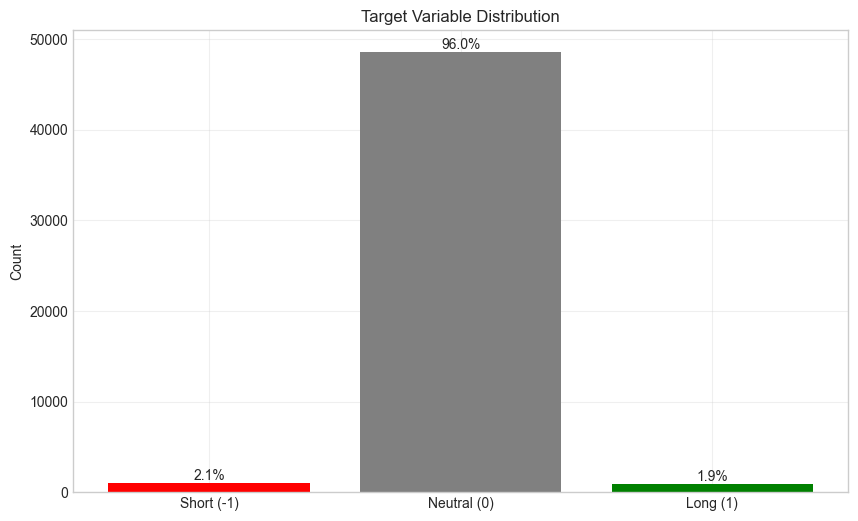

In [28]:
# Plot target distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(['Short (-1)', 'Neutral (0)', 'Long (1)'], 
              [target_counts.get(-1, 0), target_counts.get(0, 0), target_counts.get(1, 0)],
              color=['red', 'gray', 'green'])

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/len(df_target)*100:.1f}%',
            ha='center', va='bottom')

plt.title('Target Variable Distribution')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Feature Correlation Analysis

Let's analyze which features are most correlated with our target variable.

In [29]:
# Calculate correlation with target
target_corr = df_target.corr()['Target'].sort_values(ascending=False)

# Print top positive correlations
print("Top Positive Correlations with Target:")
print(target_corr.head(15))

# Print top negative correlations
print("\nTop Negative Correlations with Target:")
print(target_corr.tail(15))

Top Positive Correlations with Target:
Target                1.0000
Volume                0.0441
Volume_SMA20          0.0408
Volume_Trend          0.0089
HourOfDay             0.0074
DayOfWeek             0.0053
High_Volume           0.0027
Volume_Ratio          0.0010
Close_SMA200_Ratio    0.0005
Golden_Cross         -0.0013
Death_Cross          -0.0013
MACD_Cross_Below     -0.0016
Daily_Return         -0.0047
Weekly_Return        -0.0049
MACD_Cross_Above     -0.0053
Name: Target, dtype: float64

Top Negative Correlations with Target:
Close_SMA20_Ratio   -0.0207
Monthly_Return      -0.0250
ATR                 -0.0276
BB_Lower            -0.0858
SMA20               -0.0860
BB_Middle           -0.0860
EMA26               -0.0861
SMA50               -0.0861
Low                 -0.0861
EMA12               -0.0861
Open                -0.0861
Close               -0.0862
High                -0.0862
BB_Upper            -0.0862
SMA200              -0.0891
Name: Target, dtype: float64


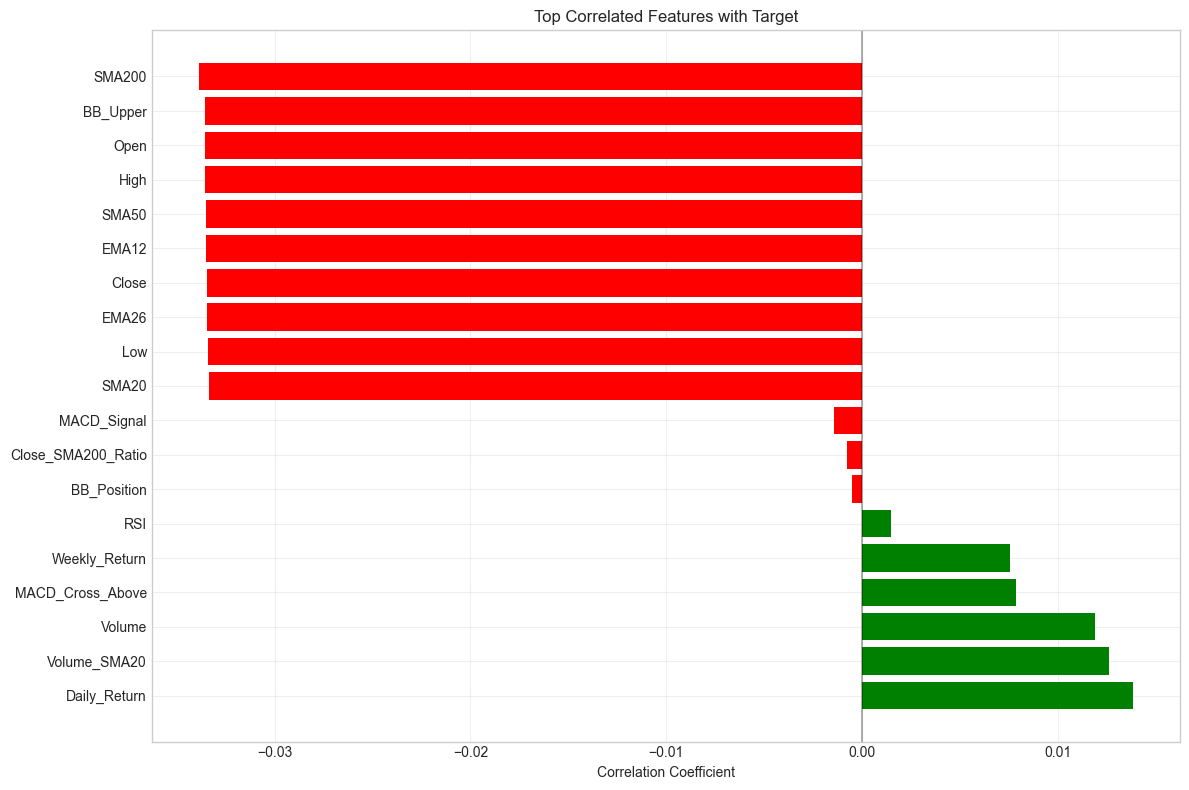

In [10]:
# Plot top correlations
plt.figure(figsize=(12, 8))
top_features = pd.concat([target_corr.head(10), target_corr.tail(10)])
top_features = top_features[top_features.index != 'Target']  # Remove target itself
colors = ['green' if c > 0 else 'red' for c in top_features]
plt.barh(top_features.index, top_features, color=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Top Correlated Features with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Feature Preparation Pipeline

Now let's use our complete feature preparation pipeline to get a clean dataset ready for modeling.

In [30]:
# Prepare all features in one go
df_features = prepare_features(
    df, 
    include_target=True, 
    future_periods=future_periods, 
    profit_target=profit_target, 
    stop_loss=stop_loss
)

print(f"Final dataset shape: {df_features.shape}")
print(f"Number of features: {df_features.shape[1] - 1}")  # Excluding target
print(f"Number of samples: {df_features.shape[0]}")
print(f"\nFirst few rows:")
df_features.head()

Final dataset shape: (49815, 37)
Number of features: 36
Number of samples: 49815

First few rows:


,Open,High,Low,Close,Volume,SMA20,SMA50,SMA200,EMA12,EMA26,RSI,MACD,MACD_Signal,MACD_Hist,ATR,BB_Upper,BB_Middle,BB_Lower,ADX,Close_SMA20_Ratio,Close_SMA50_Ratio,Close_SMA200_Ratio,BB_Position,Golden_Cross,Death_Cross,MACD_Cross_Above,MACD_Cross_Below,Daily_Return,Weekly_Return,Monthly_Return,DayOfWeek,HourOfDay,Volume_SMA20,Volume_Ratio,High_Volume,Volume_Trend,Target
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-04 07:45:00+07:00,10865.1790,10869.4990,10863.0590,10865.8590,615540.9981,10857.3405,10875.2554,10940.9238,10860.8206,10860.0048,52.7617,0.8158,-3.4886,4.3045,17.0433,10875.9420,10857.3405,10838.7390,12.2436,1.0008,0.9991,0.9931,0.7290,0,0,0,0,0.0001,0.0005,0.0009,2,7,697819.3479,0.8821,0,-74950.1568,0
2023-01-04 08:00:00+07:00,10866.2890,10888.4990,10864.2790,10886.5190,699310.9899,10858.0900,10872.6398,10940.5642,10864.7742,10861.9688,61.0539,2.8054,-2.2298,5.0352,17.5559,10879.8566,10858.0900,10836.3234,13.0270,1.0026,1.0013,0.9951,1.1530,0,0,0,0,0.0019,0.0020,0.0014,2,8,623132.4981,1.1223,0,-51319.9744,0
2023-01-04 08:15:00+07:00,10886.7390,10889.3890,10883.1290,10888.5890,632279.0048,10859.4235,10870.1950,10940.2150,10868.4380,10863.9406,61.7779,4.4974,-0.8844,5.3818,16.7490,10884.9142,10859.4235,10833.9328,13.8060,1.0027,1.0017,0.9953,1.0721,0,0,0,0,0.0002,0.0020,0.0025,2,8,546456.6992,1.1571,0,-26831.4813,0
2023-01-04 08:30:00+07:00,10888.5670,10900.7990,10885.5290,10895.6290,876665.0111,10861.2760,10868.1340,10939.9009,10872.6212,10866.2879,64.2143,6.3333,0.5591,5.7742,16.6434,10891.2439,10861.2760,10831.3081,15.1534,1.0032,1.0025,0.9960,1.0732,0,0,0,0,0.0006,0.0017,0.0034,2,8,482007.6489,1.8188,1,3451.9274,0
2023-01-04 08:45:00+07:00,10895.9190,10898.0990,10893.3190,10893.7990,625564.0090,10862.8965,10865.8866,10939.5777,10875.8794,10868.3258,63.0885,7.5536,1.9580,5.5955,15.7960,10896.0494,10862.8965,10829.7436,16.4046,1.0028,1.0026,0.9958,0.9661,0,0,0,0,-0.0002,0.0026,0.0030,2,8,407530.2006,1.5350,1,31288.6061,0


## 7. Feature Selection Analysis

Let's perform basic feature selection to understand which features might be most predictive.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Define features and target
X = df_features.drop(['Target'], axis=1)
y = df_features['Target']

# Replace any remaining NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Train a Random Forest for feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 20 features
print("Top 20 features by importance:")
for i in range(20):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")

Top 20 features by importance:
1. SMA200: 0.0785
2. Close_SMA200_Ratio: 0.0630
3. SMA50: 0.0532
4. EMA26: 0.0470
5. BB_Upper: 0.0429
6. EMA12: 0.0410
7. ATR: 0.0401
8. BB_Middle: 0.0399
9. BB_Lower: 0.0397
10. SMA20: 0.0397
11. Close: 0.0353
12. Low: 0.0325
13. Volume_SMA20: 0.0324
14. MACD_Signal: 0.0323
15. High: 0.0319
16. Open: 0.0304
17. ADX: 0.0299
18. DayOfWeek: 0.0288
19. HourOfDay: 0.0286
20. MACD: 0.0253


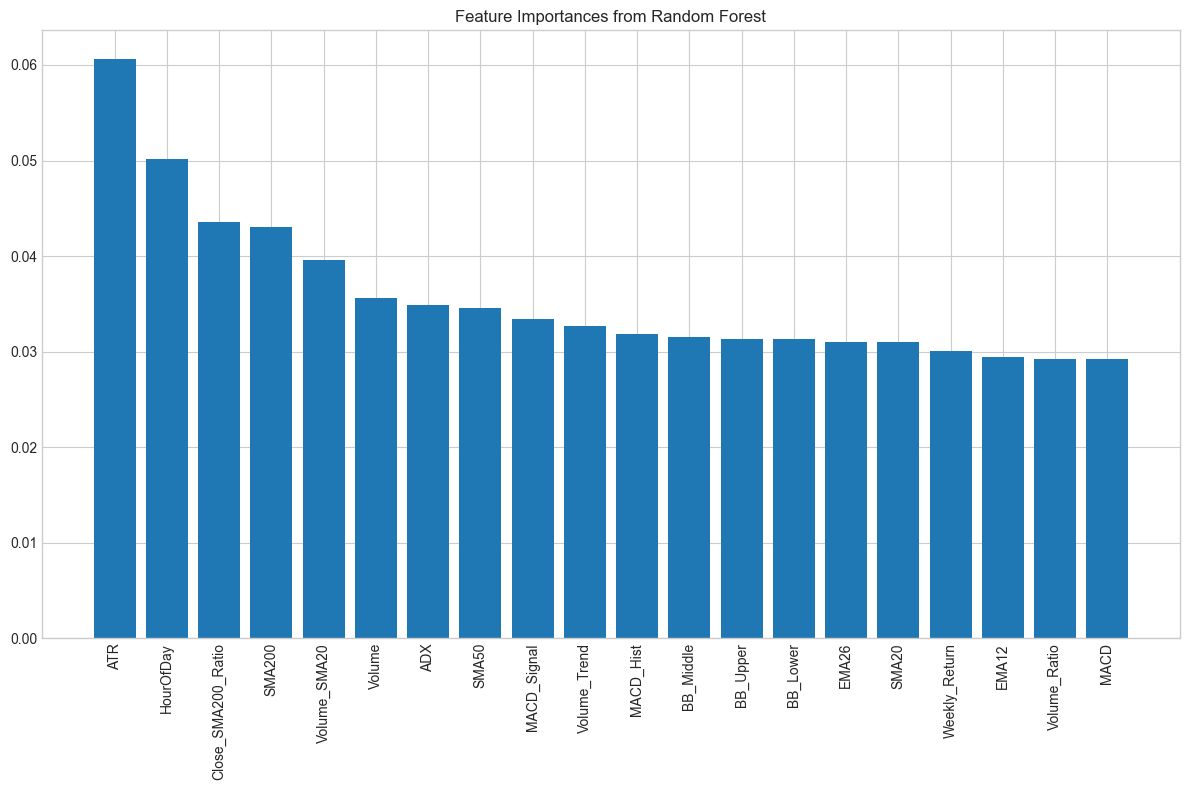

In [13]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances from Random Forest")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), X.columns[indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

## 8. Save Processed Dataset

Finally, let's save our processed dataset for use in later notebooks.

In [32]:
# Save processed dataset
df_features.to_csv('../processed_data.csv')
print(f"Saved processed dataset with {df_features.shape[1]} columns and {df_features.shape[0]} rows to '../processed_data.csv'")

Saved processed dataset with 37 columns and 49815 rows to '../processed_data.csv'


## Summary

In this notebook, we've completed the following steps:

1. Loaded and preprocessed the USATECH index data
2. Added technical indicators like moving averages, RSI, MACD, and Bollinger Bands
3. Created price and volume-based features
4. Generated a target variable based on future price movements
5. Analyzed feature correlations with the target
6. Used our complete feature preparation pipeline
7. Performed feature importance analysis
8. Saved the processed dataset for use in model training

Next, we'll use this processed dataset to train our trading model in the next notebook.